# Imports 

In [3]:
# current filepath system leaves plenty to be desired
import sys
local_path = '/Users/hinzlehome/codeup-data-science/anomaly-detection-exercises/'
sys.path.insert(0, local_path)

# imports.py in /utils/
from utils.imports import *

# plotting magic
%matplotlib inline
# plotting defaults
plt.rc('figure', figsize=(16, 9))
plt.style.use('seaborn-darkgrid')
plt.rc('font', size=16)
# plt.style.available
# # ^^^ show available seaborn styles

# # !!! Warning !!! 
# # *** no more warnings ***
# import warnings
# warnings.filterwarnings("ignore")

# # custom mods
# from utils.tidy import *
# from utils.model import *


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Tidy

In [ ]:
# first run
# url=get_db_url('logs')
# df = pd.read_sql('SELECT * FROM api_access', url)
# df.to_csv('/Users/hinzlehome/codeup-data-science/anomaly-detection-exercises/csv/logs.csv')
# # cached
# df = pd.read_csv('/Users/hinzlehome/codeup-data-science/anomaly-detection-exercises/csv/logs.csv')

In [ ]:
# # first run
# # function to deal with parsing one entry in our log data
# def parse_log_entry(entry):
#     parts = entry.split()
#     output = {}
#     output['ip'] = parts[0]
#     output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
#     output['request_method'] = parts[5][1:]
#     output['request_path'] = parts[6]
#     output['http_version'] = parts[7][:-1]
#     output['status_code'] = parts[8]
#     output['size'] = int(parts[9])
#     output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
#     return pd.Series(output)

# df = df.entry.apply(parse_log_entry)

# df.to_csv('/Users/hinzlehome/codeup-data-science/anomaly-detection-exercises/csv/tidy_logs.csv',index=False)


In [4]:
# returns tidy logs if previously cached from db
df=pd.read_csv('/Users/hinzlehome/codeup-data-science/anomaly-detection-exercises/csv/tidy_logs.csv')

In [5]:
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


# Adding Errors

In [6]:
new = pd.DataFrame([
    ["95.31.18.119", "21/Apr/2019 10:02:41", "GET", "/api/v1/items/", "HTTP/1.1", '200', 1153005, "python-requests/2.21.0"],
    ["95.31.16.121", "17/Apr/2019 19:36:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 1005, "python-requests/2.21.0"],
    ["97.105.15.120", "18/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 2560, "python-requests/2.21.0"],
    ["97.105.19.58", "19/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '200', 2056327, "python-requests/2.21.0"],
], columns=df.columns)

df = df.append(new)


/var/folders/mk/w2hz4wxx7xn5hr_56wz536gh0000gn/T/ipykernel_21480/447971755.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new)


In [7]:
df['size_mb'] = df['size'] / 1024 / 1024
df.timestamp = pd.to_datetime(df.timestamp)
df = df.set_index('timestamp')


# Detecting Anomalies in Discrete Variables

In [8]:
df.head()

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246


In [9]:
[df[col].value_counts().head() for col in df.columns]


[97.105.19.58      11999
 173.173.113.51     1059
 72.181.113.170      613
 72.181.105.81       246
 68.201.219.223       21
 Name: ip, dtype: int64,
 GET    13978
 Name: request_method, dtype: int64,
 /api/v1/sales?page=2    709
 /api/v1/items           464
 /api/v1/items?page=2    291
 /api/v1/items?page=3    219
 /api/v1/stores          162
 Name: request_path, dtype: int64,
 HTTP/1.1    13978
 Name: http_version, dtype: int64,
 200    13958
 499       16
 200        2
 301        2
 Name: status_code, dtype: int64,
 494819    705
 3561      548
 3659      291
 1328      229
 1787      219
 Name: size, dtype: int64,
 python-requests/2.21.0                                                                                                       12005
 python-requests/2.20.1                                                                                                        1911
 Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 

From the code below:

this looks interesting:

	Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36    0.002432
	Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0                                           0.000572
	Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots)                                                                   0.000501

In [10]:
[df[col].value_counts(normalize=True).head() for col in df.columns]


[97.105.19.58      0.858420
 173.173.113.51    0.075762
 72.181.113.170    0.043855
 72.181.105.81     0.017599
 68.201.219.223    0.001502
 Name: ip, dtype: float64,
 GET    1.0
 Name: request_method, dtype: float64,
 /api/v1/sales?page=2    0.050723
 /api/v1/items           0.033195
 /api/v1/items?page=2    0.020818
 /api/v1/items?page=3    0.015667
 /api/v1/stores          0.011590
 Name: request_path, dtype: float64,
 HTTP/1.1    1.0
 Name: http_version, dtype: float64,
 200    0.998569
 499    0.001145
 200    0.000143
 301    0.000143
 Name: status_code, dtype: float64,
 494819    0.050436
 3561      0.039204
 3659      0.020818
 1328      0.016383
 1787      0.015667
 Name: size, dtype: float64,
 python-requests/2.21.0                                                                                                       0.858850
 python-requests/2.20.1                                                                                                       0.136715
 Mozilla/5.0 (Maci

In [46]:
def value_counts_and_frequencies(s: pd.Series, dropna=True) -> pd.DataFrame:
    new=pd.merge(
    s.value_counts(dropna=False).rename('count'),
    s.value_counts(dropna=False, normalize=True).rename('proba'),
    left_index=True,
    right_index=True,
    )
    print(new)



In [50]:
df.apply(value_counts_and_frequencies)

                count     proba
97.105.19.58    11999  0.858420
173.173.113.51   1059  0.075762
72.181.113.170    613  0.043855
72.181.105.81     246  0.017599
68.201.219.223     21  0.001502
24.26.242.9        21  0.001502
35.175.171.137      2  0.000143
52.87.230.102       2  0.000143
70.121.214.34       2  0.000143
52.90.165.200       1  0.000072
95.31.16.121        1  0.000072
95.31.18.119        1  0.000072
45.23.250.16        1  0.000072
52.91.30.150        1  0.000072
34.207.64.242       1  0.000072
3.88.129.158        1  0.000072
54.172.14.223       1  0.000072
3.92.201.136        1  0.000072
35.174.209.2        1  0.000072
54.145.52.184       1  0.000072
34.229.70.250       1  0.000072
97.105.15.120       1  0.000072
     count  proba
GET  13978    1.0
                                         count     proba
/api/v1/sales?page=2                       709  0.050723
/api/v1/items                              464  0.033195
/api/v1/items?page=2                       291  0.020818


ip                None
request_method    None
request_path      None
http_version      None
status_code       None
size              None
user_agent        None
size_mb           None
dtype: object

ip


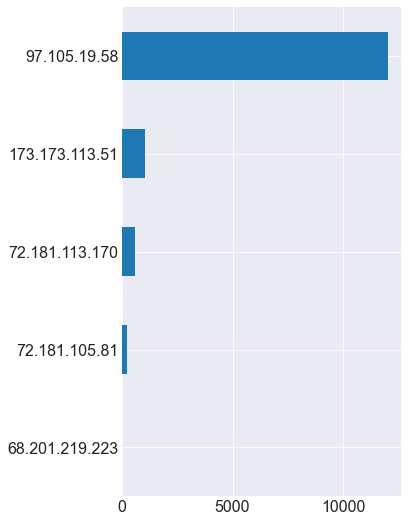

request_method


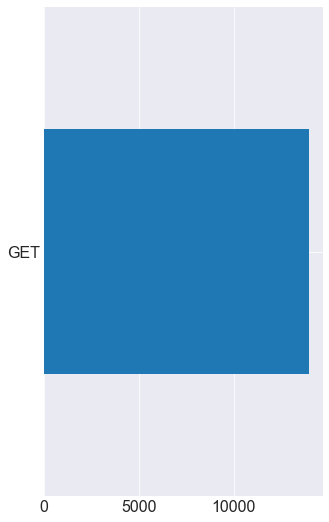

request_path


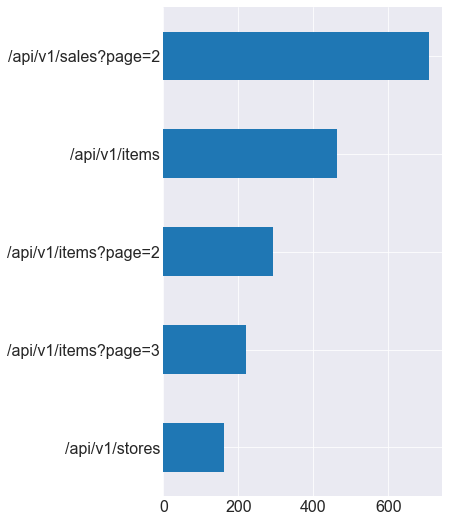

http_version


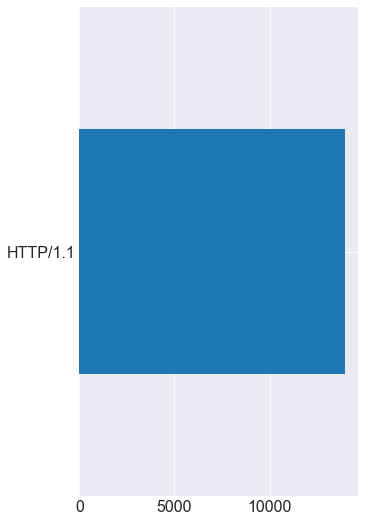

status_code


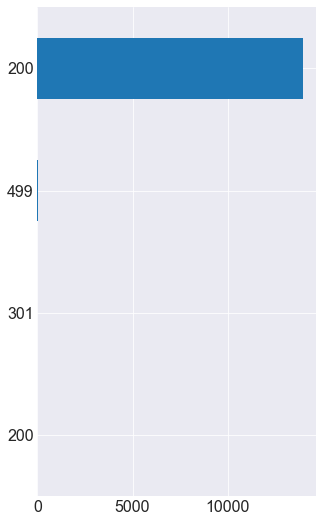

size


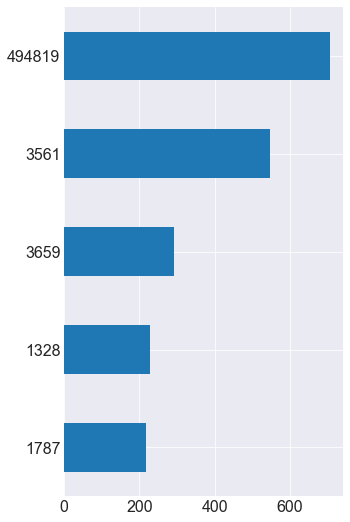

user_agent


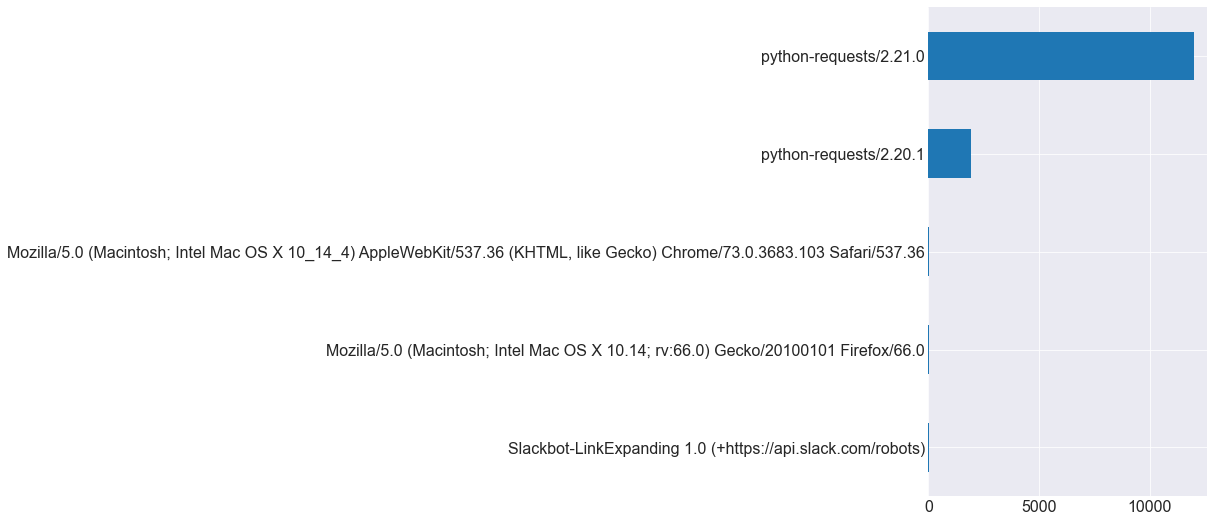

size_mb


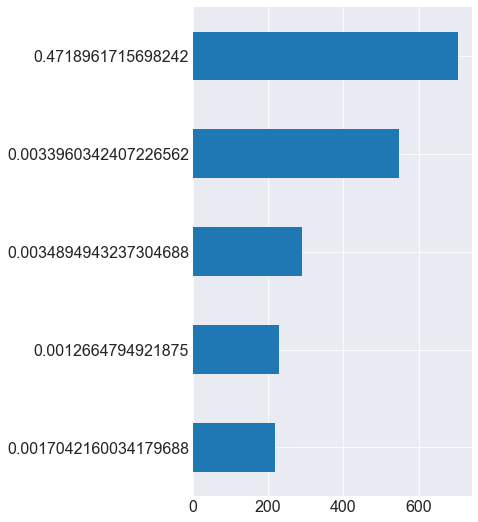

In [64]:
for col in df.columns:
	print(col)
	new=df[col].value_counts(dropna=False).rename('count')
	new.sort_values().tail(5).plot.barh(figsize=(5, 9))
	plt.show()

# Conditional Probabilities: Probabilities Using 2 Discrete Variables

In [13]:
status_given_ip = (
    df.groupby('ip')
    .status_code.value_counts(normalize=True)
    .rename('proba_status_given_ip')
    .reset_index()
)
status_given_ip.head()


,ip,status_code,proba_status_given_ip
0,173.173.113.51,200,1.0
1,24.26.242.9,200,1.0
2,3.88.129.158,200,1.0
3,3.92.201.136,200,1.0
4,34.207.64.242,200,1.0


In [14]:
status_given_ip[status_given_ip.status_code != '200']


,ip,status_code,proba_status_given_ip
0,173.173.113.51,200,1.000000
1,24.26.242.9,200,1.000000
2,3.88.129.158,200,1.000000
3,3.92.201.136,200,1.000000
4,34.207.64.242,200,1.000000
5,34.229.70.250,200,1.000000
6,35.174.209.2,200,1.000000
7,35.175.171.137,200,1.000000
8,45.23.250.16,200,1.000000
9,52.87.230.102,200,1.000000


In [15]:
status_given_ip[status_given_ip.proba_status_given_ip < 1]


,ip,status_code,proba_status_given_ip
17,72.181.113.170,200,0.996737
18,72.181.113.170,499,0.003263
22,97.105.19.58,200,0.998750
23,97.105.19.58,499,0.001167
24,97.105.19.58,200,0.000083


# Working

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13978 entries, 2019-04-16 19:34:42 to 2019-04-19 19:42:41
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ip              13978 non-null  object 
 1   request_method  13978 non-null  object 
 2   request_path    13978 non-null  object 
 3   http_version    13978 non-null  object 
 4   status_code     13978 non-null  object 
 5   size            13978 non-null  int64  
 6   user_agent      13978 non-null  object 
 7   size_mb         13978 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 982.8+ KB


In [98]:
col='ip'
df.groupby([col])[col].value_counts()

# this looks weird: lookes like someone tried to query the server 12000 from a list with index 0.
# 97.105.19.58    97.105.19.58      11999


ip              ip            
173.173.113.51  173.173.113.51     1059
24.26.242.9     24.26.242.9          21
3.88.129.158    3.88.129.158          1
3.92.201.136    3.92.201.136          1
34.207.64.242   34.207.64.242         1
34.229.70.250   34.229.70.250         1
35.174.209.2    35.174.209.2          1
35.175.171.137  35.175.171.137        2
45.23.250.16    45.23.250.16          1
52.87.230.102   52.87.230.102         2
52.90.165.200   52.90.165.200         1
52.91.30.150    52.91.30.150          1
54.145.52.184   54.145.52.184         1
54.172.14.223   54.172.14.223         1
68.201.219.223  68.201.219.223       21
70.121.214.34   70.121.214.34         2
72.181.105.81   72.181.105.81       246
72.181.113.170  72.181.113.170      613
95.31.16.121    95.31.16.121          1
95.31.18.119    95.31.18.119          1
97.105.15.120   97.105.15.120         1
97.105.19.58    97.105.19.58      11999
Name: ip, dtype: int64

In [103]:
df.columns.to_list()

['ip',
 'request_method',
 'request_path',
 'http_version',
 'status_code',
 'size',
 'user_agent',
 'size_mb']

In [108]:
[df.groupby([col])[col].value_counts() for col in df.columns]


[ip              ip            
 173.173.113.51  173.173.113.51     1059
 24.26.242.9     24.26.242.9          21
 3.88.129.158    3.88.129.158          1
 3.92.201.136    3.92.201.136          1
 34.207.64.242   34.207.64.242         1
 34.229.70.250   34.229.70.250         1
 35.174.209.2    35.174.209.2          1
 35.175.171.137  35.175.171.137        2
 45.23.250.16    45.23.250.16          1
 52.87.230.102   52.87.230.102         2
 52.90.165.200   52.90.165.200         1
 52.91.30.150    52.91.30.150          1
 54.145.52.184   54.145.52.184         1
 54.172.14.223   54.172.14.223         1
 68.201.219.223  68.201.219.223       21
 70.121.214.34   70.121.214.34         2
 72.181.105.81   72.181.105.81       246
 72.181.113.170  72.181.113.170      613
 95.31.16.121    95.31.16.121          1
 95.31.18.119    95.31.18.119          1
 97.105.15.120   97.105.15.120         1
 97.105.19.58    97.105.19.58      11999
 Name: ip, dtype: int64,
 request_method  request_method
 GET     

In [109]:
[[df.groupby([col])[loc].value_counts() for col in df.columns] for loc in df.columns] 

[[ip              ip            
  173.173.113.51  173.173.113.51     1059
  24.26.242.9     24.26.242.9          21
  3.88.129.158    3.88.129.158          1
  3.92.201.136    3.92.201.136          1
  34.207.64.242   34.207.64.242         1
  34.229.70.250   34.229.70.250         1
  35.174.209.2    35.174.209.2          1
  35.175.171.137  35.175.171.137        2
  45.23.250.16    45.23.250.16          1
  52.87.230.102   52.87.230.102         2
  52.90.165.200   52.90.165.200         1
  52.91.30.150    52.91.30.150          1
  54.145.52.184   54.145.52.184         1
  54.172.14.223   54.172.14.223         1
  68.201.219.223  68.201.219.223       21
  70.121.214.34   70.121.214.34         2
  72.181.105.81   72.181.105.81       246
  72.181.113.170  72.181.113.170      613
  95.31.16.121    95.31.16.121          1
  95.31.18.119    95.31.18.119          1
  97.105.15.120   97.105.15.120         1
  97.105.19.58    97.105.19.58      11999
  Name: ip, dtype: int64,
  request_method 